In [2]:
import Pkg
Pkg.activate("../../Tasks2D")
using Revise

includet("07_src.jl")

  Activating project at `~/Developer/research/summer2023/tasks2d/Tasks2D`


In [3]:
(_segs, _bb, _center) = L.load_env_sparse("/Users/georgematheos/Developer/research/summer2023/tasks2d/data/environments/ambig.json");

In [4]:
ϵ = 0.25
(grid, edges, l_to_g, g_to_l) = line_to_grid(_segs, _bb, ϵ)
w = GridWorlds.boolmatrix_to_grid(grid, (length(edges[1]), length(edges[2])));

In [5]:
PARAMS = (;
    map = _segs,
    orientation = π/2,
    bounding_box = L.bounding_box(_segs),
    step = (;
        Δ = 0.25,
        σ = 0.02
    ),
    obs = (;
        fov = 2π,
        n_rays = 40,
        sensor_args = (;
            w            = 5,
            s_noise      = 0.02,
            outlier      = 0.0001,
            outlier_vol = 100.0,
            zmax = 100.0
        )
    )
);

In [207]:
### Particle Filter args ###
_grid_args = (;
    tau = 1., # "temperature" for grid proposal
    pmin = 1e-6,
    init_grid_args = (;
        k = [9, 9],    # number of grid cells along each dimension
        r = [PARAMS.step.Δ/3, PARAMS.step.Δ/3] # size of grid cells at first iteration
    ),
    n_iters = 5 # number of iterations of grid proposals
)

_t0_grid_args = (;
    _grid_args...,
    tau=20.,
    n_iters=6, # more iterations for the initial step

    # TODO: set this up to automatically look at the bounding box
    init_grid_args = (; k=[7, 13], r=[.8, .8]),
    initial_pos = [2.7, 6.] # center of grid for first timestep
)

PARAMS_NOISYSTEP = (;
    map = _segs,
    orientation = π/2,
    bounding_box = L.bounding_box(_segs),
    step = (;
        Δ = 0.25,
        σ = 0.1
    ),
    obs = (;
        fov = 2π,
        n_rays = 40,
        sensor_args = (;
            w            = 5,
            s_noise      = 0.02,
            outlier      = 0.0001,
            outlier_vol = 100.0,
            zmax = 100.0
        )
    )
);

_resampling_args = (;
    n_particles=20,
    n_groups=5,
    ess_threshold=1+1e-4
)

pf = @get_pf(PARAMS_NOISYSTEP, _grid_args, _t0_grid_args, _resampling_args);

In [208]:
_t0_grid_args.tau

20.0

[ Info: Saved animation to /Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld_tasks/tmp.gif


Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld_tasks/tmp.gif")
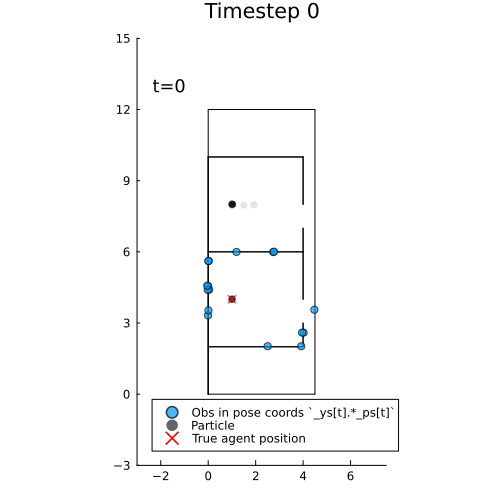

In [227]:
tr, take_action = GenPOMDPs.interactive_world_trace(trajectory_model, PARAMS, choicemap((state_addr(0, :pos), [1., 4.])));
pf_observable = GenPOMDPs.pf_observable(pf, get_actobs_seq(tr));

visualize_tr_pf(tr[], pf_observable[], 0, 0, title="Timestep 0")

In [228]:
GOAL = [1., 9.];

In [229]:
### Run Policy (policy is inlined in loop, currently...) ###

wall_following_internal_state = initial_wall_follow_state()
while Geo.norm(currentpos(tr[]) - GOAL) > .3 && T(tr[]) < 50
    _tr = GPF.sample_unweighted_traces(pf_observable[][end], 1)[1]
    pos = _tr[state_addr(T(_tr), :pos)]
    
    if there_is_ambiguity(pf_observable[][end])
        prev_st = wall_following_internal_state
        (action, next_st) = wall_follow(wall_following_internal_state, pos)
        wall_following_internal_state = next_st
        
        msg = "WF ($(prev_st[end])) -> $((action, next_st[end]))"
    else
        action = find_action_using_grid_search(pos, GOAL)[1]
        
        msg = "GS -> $action"

        # Reset the wall following policy
        wall_following_internal_state = initial_wall_follow_state()
    end
    @info msg
    
    take_action(action)
end

[ Info: WF (nothing) -> (:left, nothing)
[ Info: WF (nothing) -> (:left, nothing)
[ Info: WF (nothing) -> (:left, nothing)
[ Info: WF (nothing) -> (:down, :L)
[ Info: WF (L) -> (:down, :L)
[ Info: WF (L) -> (:down, :L)
[ Info: WF (L) -> (:down, :L)
[ Info: WF (L) -> (:down, :L)
[ Info: WF (L) -> (:down, :L)
[ Info: WF (L) -> (:down, :L)
[ Info: WF (L) -> (:right, :D)
[ Info: WF (D) -> (:right, :D)
[ Info: WF (D) -> (:right, :D)
[ Info: WF (D) -> (:right, :D)
[ Info: WF (D) -> (:right, :D)
[ Info: WF (D) -> (:right, :D)
[ Info: WF (D) -> (:right, :D)
[ Info: WF (D) -> (:right, :D)
[ Info: WF (D) -> (:right, :D)
[ Info: WF (D) -> (:right, :D)
[ Info: WF (D) -> (:right, :D)
[ Info: WF (D) -> (:right, :D)
[ Info: WF (D) -> (:right, :D)
[ Info: WF (D) -> (:right, :D)
[ Info: WF (D) -> (:right, :D)
[ Info: GS -> right
[ Info: GS -> right
[ Info: GS -> right
[ Info: GS -> right
[ Info: GS -> right
[ Info: GS -> right
[ Info: GS -> right
[ Info: GS -> right
[ Info: GS -> right
[ Info: GS -> ri

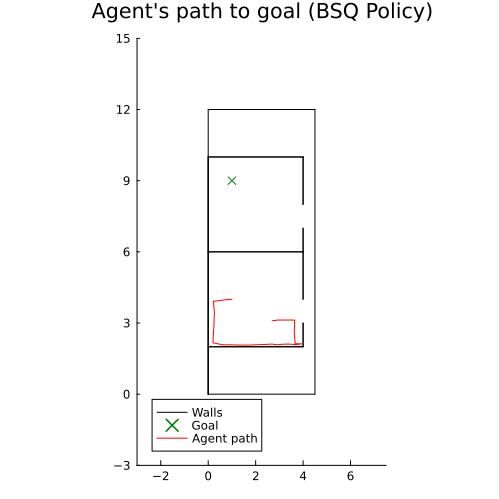

In [230]:
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Agent's path to goal (BSQ Policy)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, label="Walls")
scatter!([GOAL], c=:green, marker=:x, label="Goal")
plot!(GenPOMDPs.state_sequence(tr[]), c=:red, label="Agent path")

[ Info: Saved animation to /Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld_tasks/tmp.gif


Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld_tasks/tmp.gif")
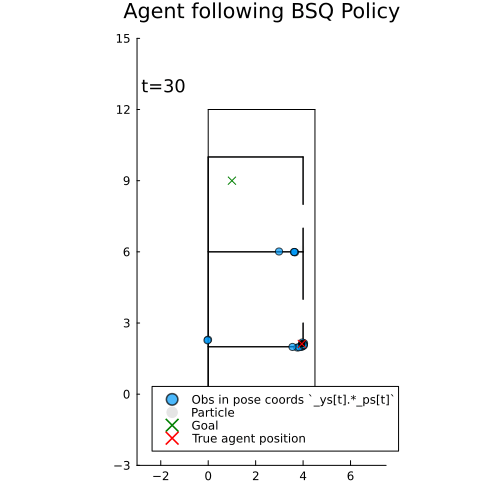

In [231]:
visualize_tr_pf(tr[], pf_observable[], 30, 50
    ; goal=GOAL, fps=3, 
    title="Agent following BSQ Policy",
    minweight=0
)